<a href="https://colab.research.google.com/github/andrea010901/analysis-grand-challenge/blob/main/L04_Shelling_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L04: Implementing the Shelling Model](https://docs.google.com/document/d/1NtGAKnsfwLRYMYrL74aMVMtTuQRJ1oDjvSFWlmMjpzs/edit?usp=sharing)
Written by Dr. Jan Pearce, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: FIXME

**SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

The design and implementation of this project centered around creating a simulation of the Schelling Model of segregation, focusing on agent-based behavior in a grid. The initial plan evolved slightly as I refined the visualization of the grid since one of the requirements was for the grid to be updated with each step. The final implementation successfully displays a dynamic grid, calculates segregation levels, and allows agents to move based on contentedness thresholds. The work took approximately 10 hours to complete, including planning, coding, and testing.

**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

none

**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

-Grid Initialization: It was very challenging to figure out how to dynamically update the grid after each step, and the only way I found was to display the grid after each step, which at the end considerably increased the total runtime, but I wasn't able to find a more efficient way.
-Agent Movement: Ensuring that agents moved to valid vacant spots without breaking the grid's requirements- moving to an empty spot and within the limits of the grid. This was challenging since at first I wasn't quite able to figure out how to efficiently handle differnt cases.

**INNOVATIONS**: Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

noce

**TESTING**: Describe how you tested this work.

I wrote a unittest suite to test this work and I also ran the implementation using different parameters to compare to what was expected.

**ERRORS**: A list in bulleted form of all known errors and deficiencies.

There are not known errors in this implemnetation.

**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab.

The only comment I have on this lab is that I would have liked to recieved more instrcutions and guidelines when it came to unittests. This is because the last time I wrote unittest was ehn I took 236 and I had a hard time thinking how to do it so I just did what seem reasonable to me. Otherwise, this lab was fun to work on.

## Import Libraries

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
import random
import numpy as np
from matplotlib.colors import ListedColormap

## The Schelling Model

Enter city width: 10
Enter city height: 10
Enter vacancy rate (0 to 1): 0.3
Enter percentage of red agents (0 to 1): 0.5
Enter contentedness level (0 to 1): 0.55
Initial Grid:


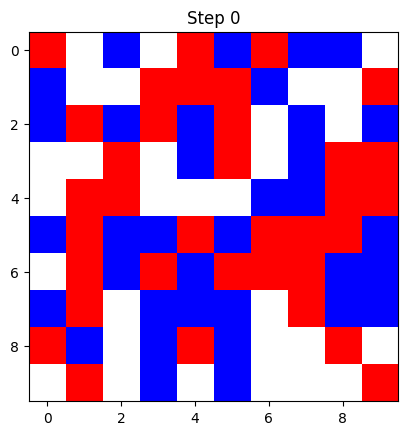

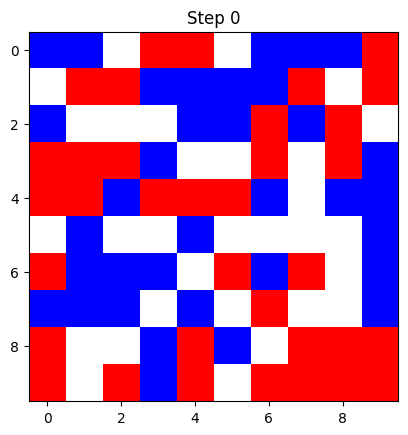

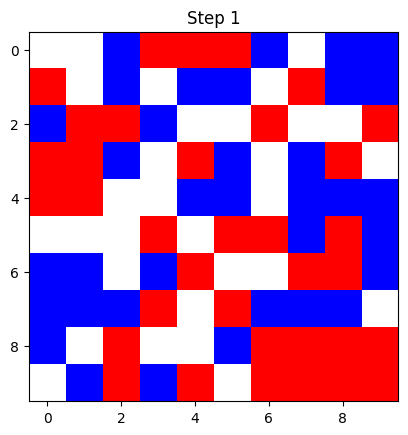

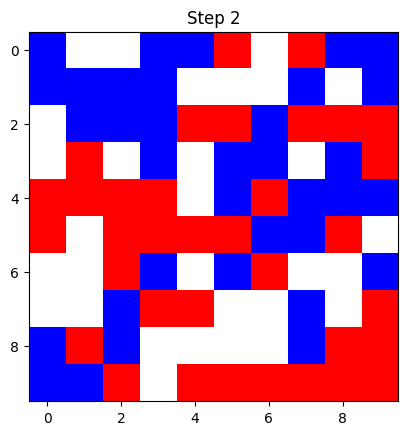

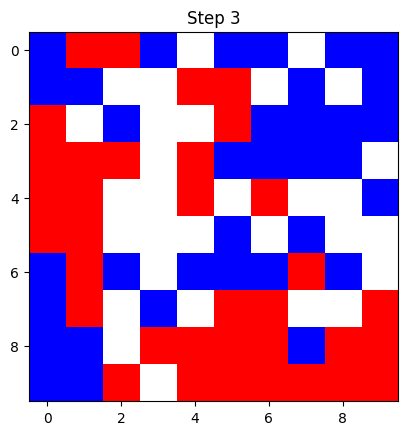

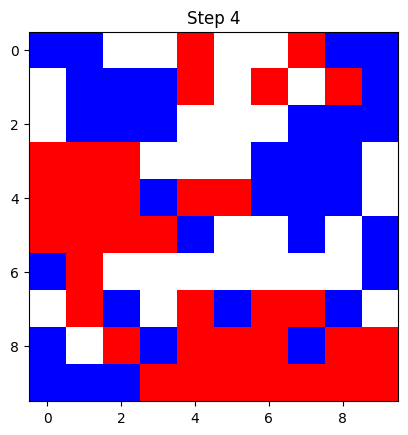

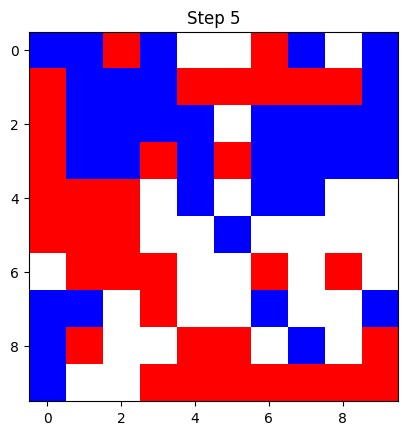

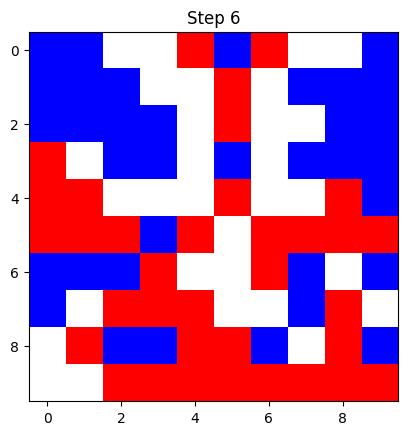

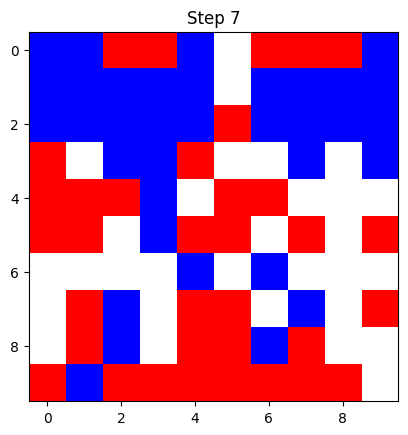

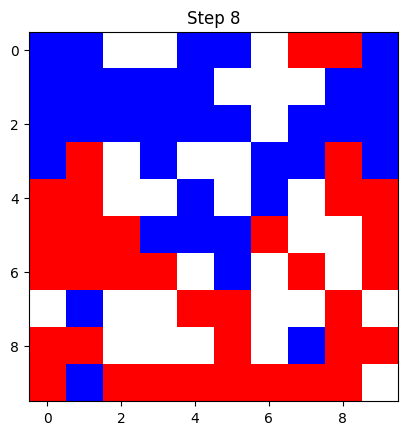

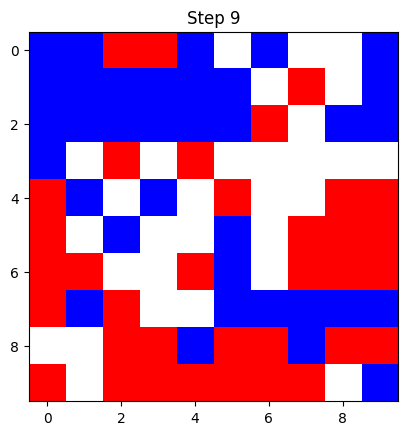

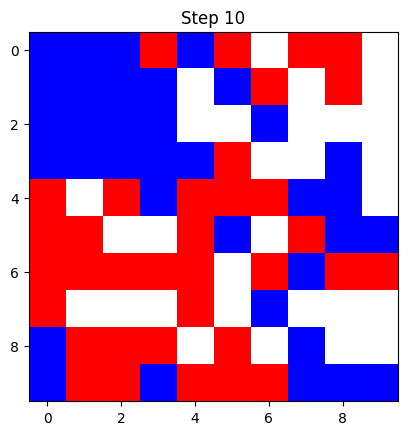

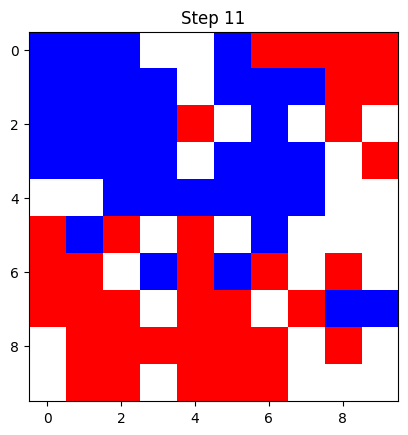

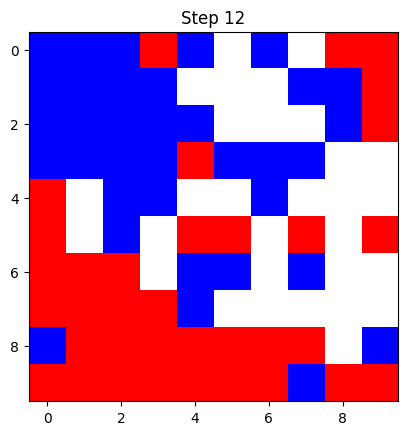

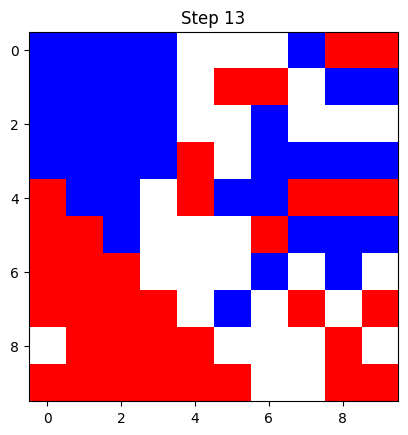

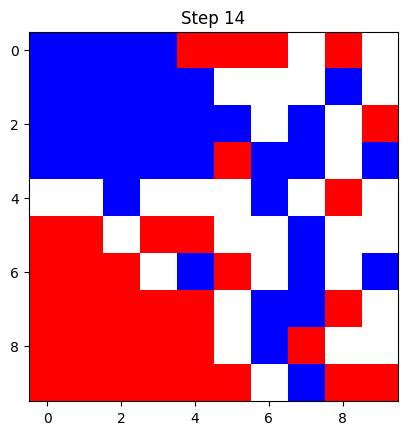

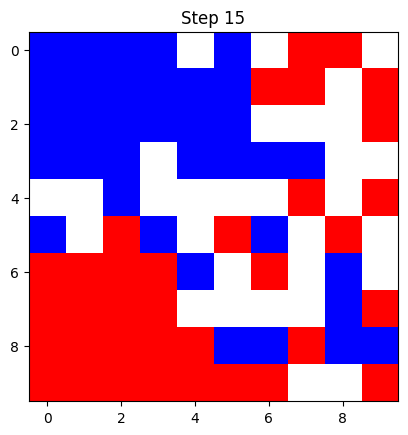

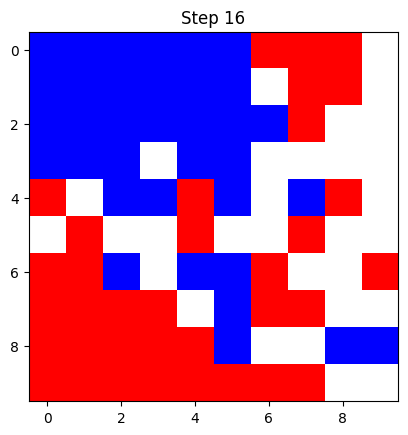

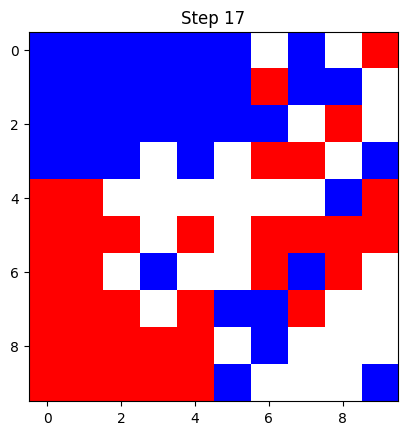

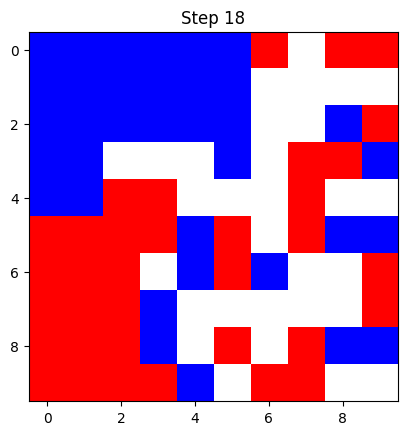

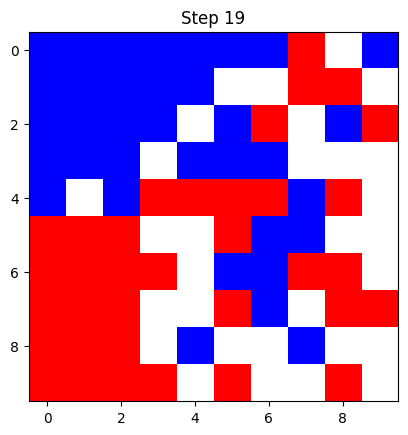

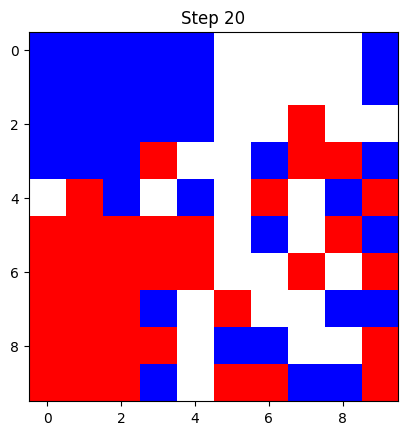

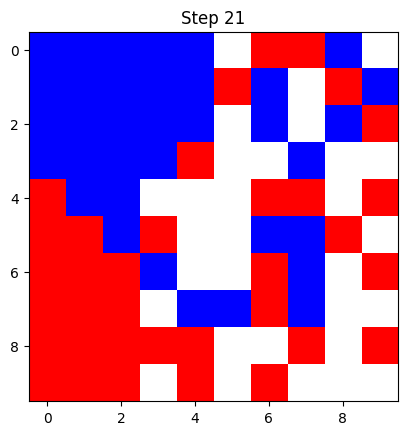

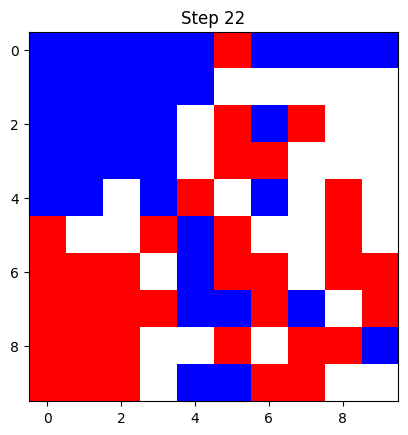

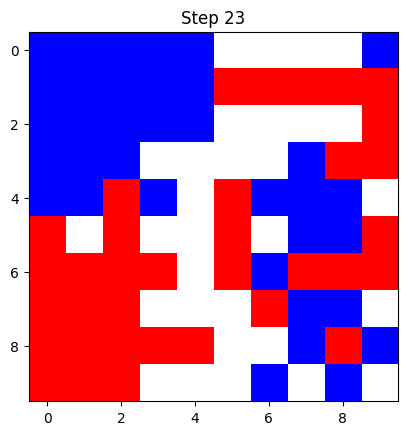

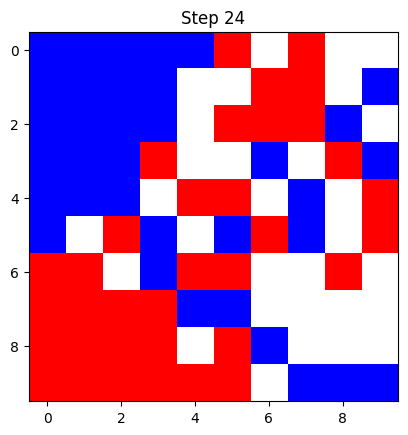

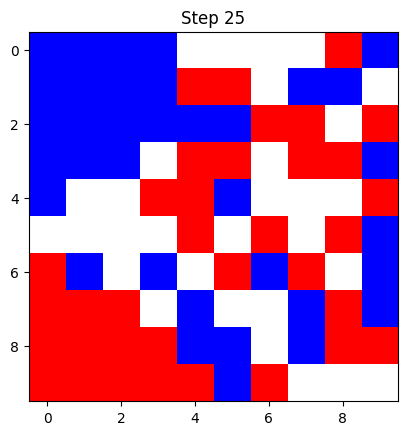

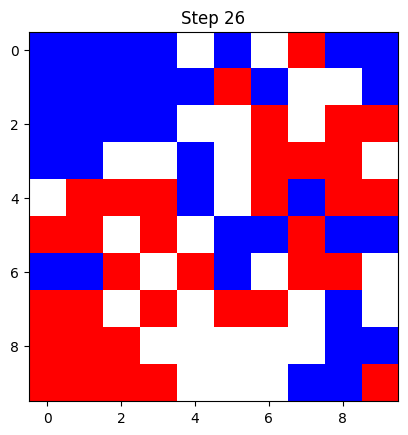

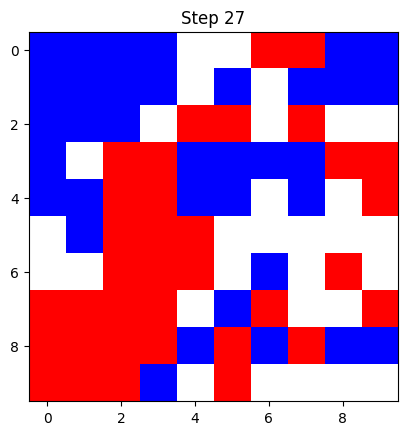

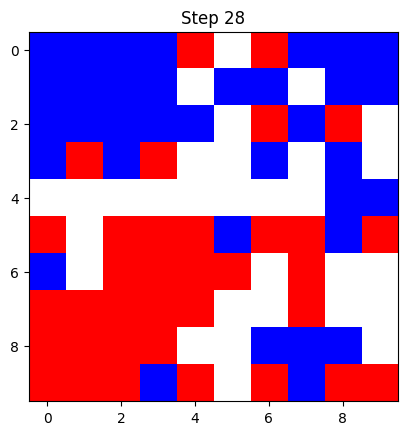

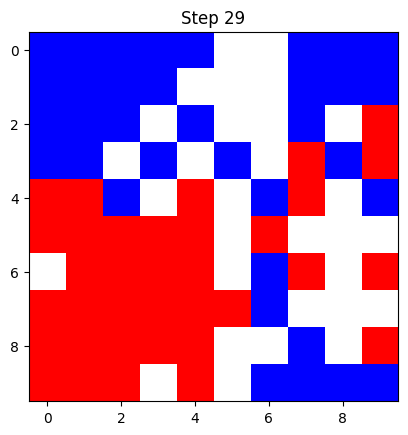

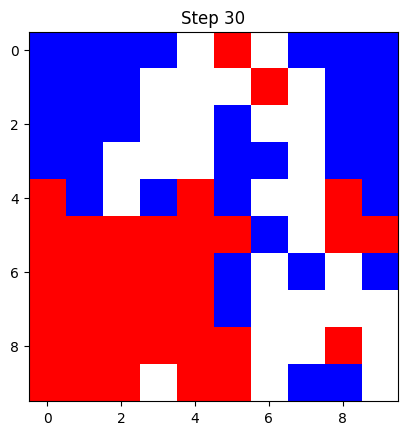

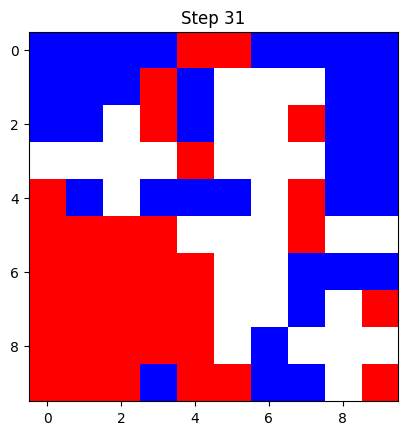

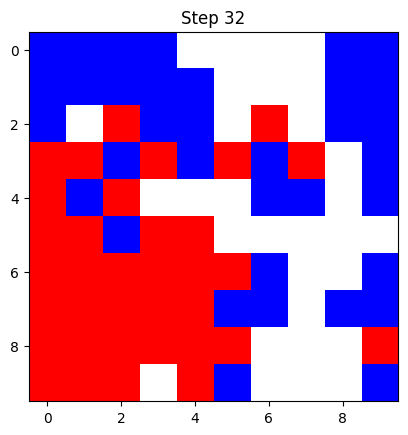

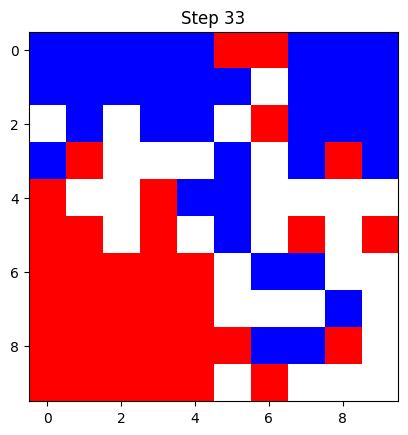

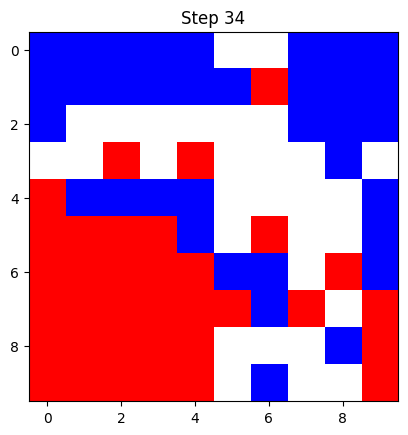

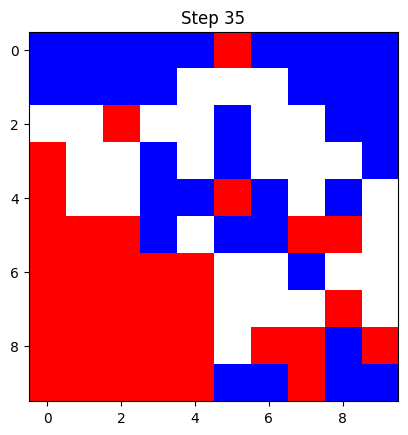

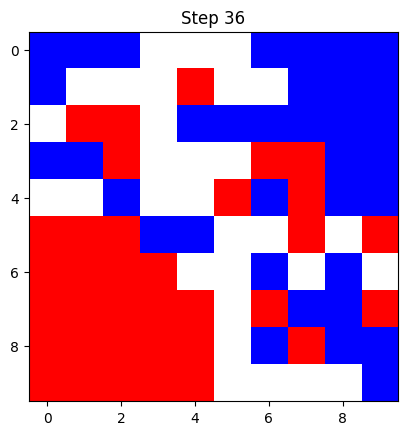

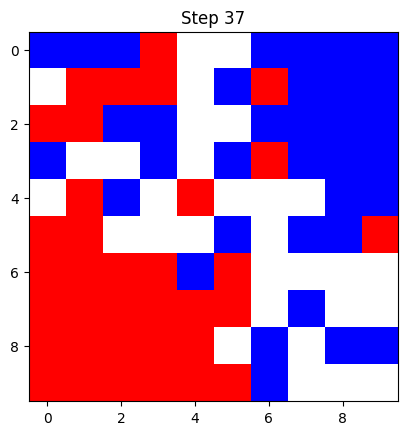

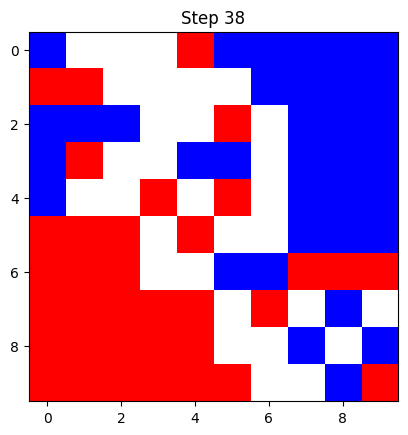

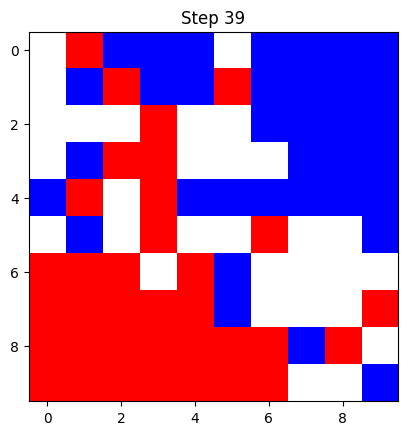

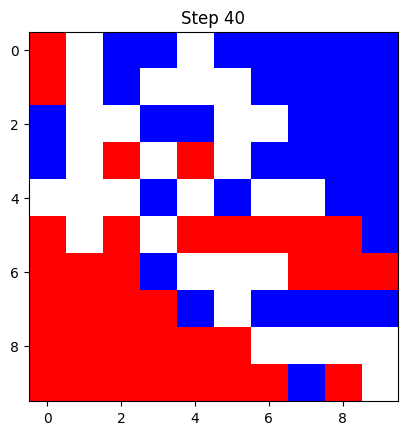

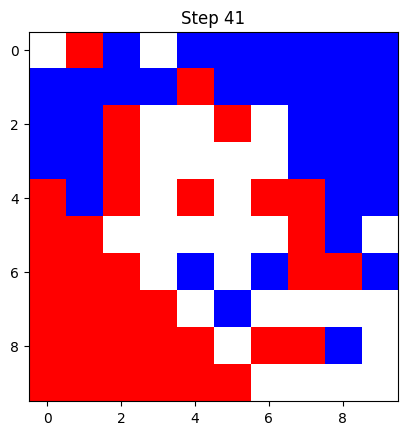

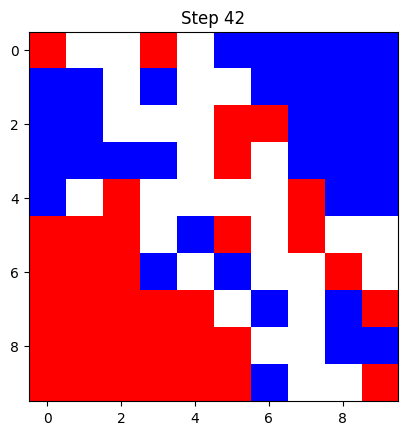

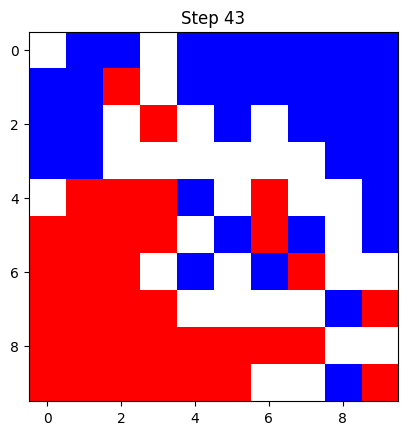

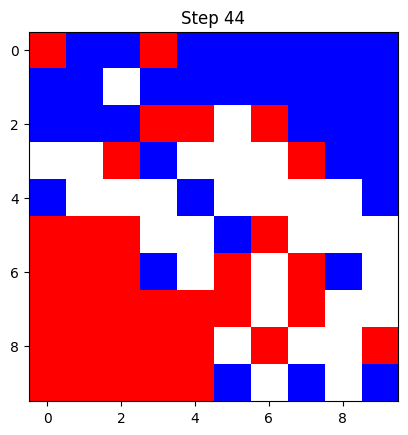

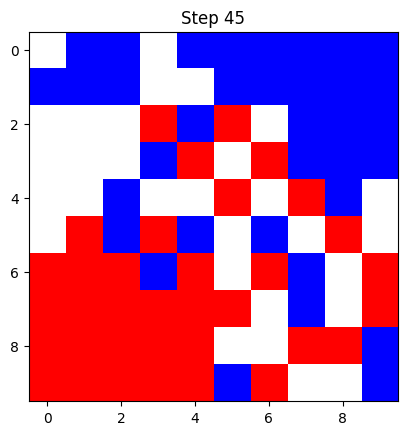

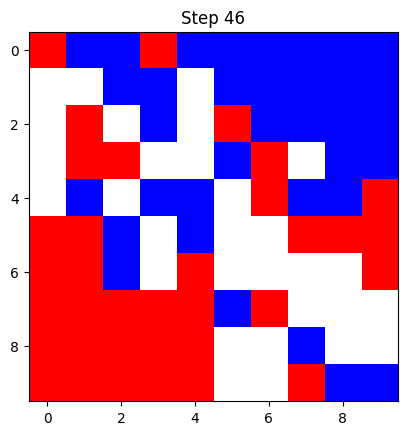

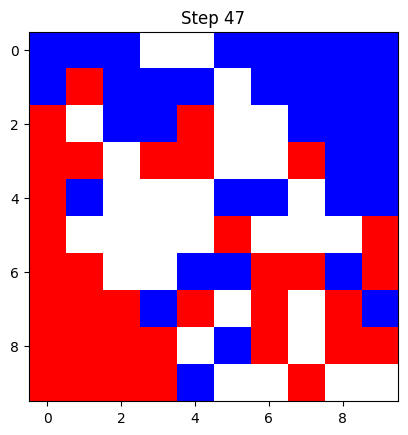

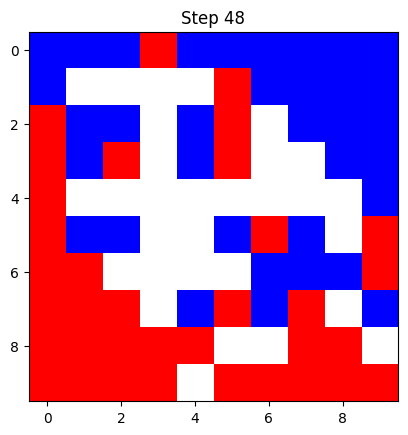

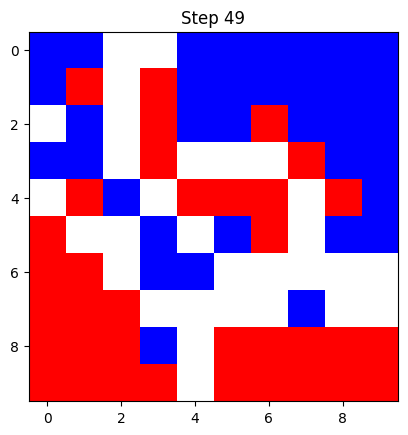

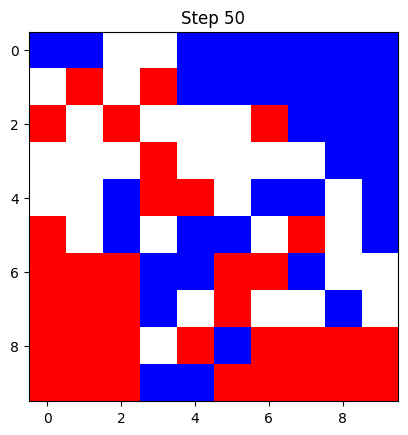

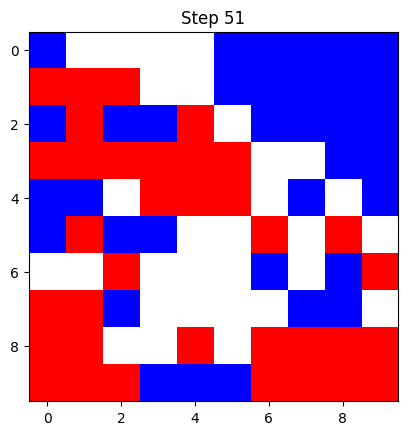

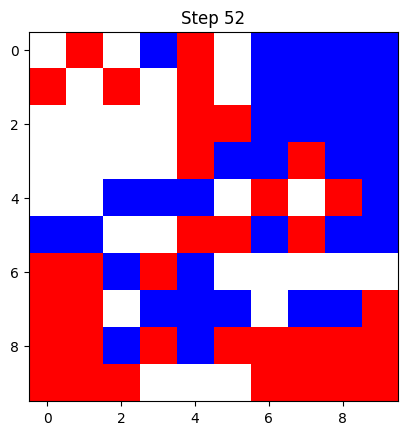

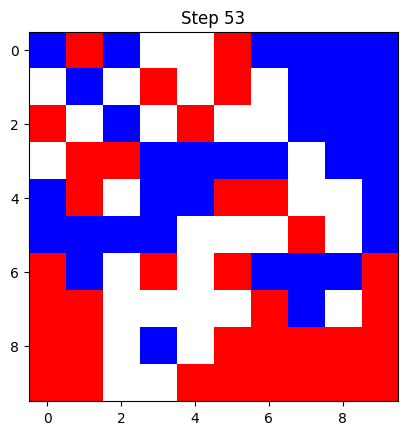

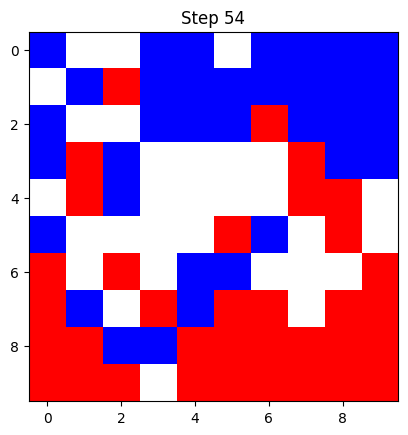

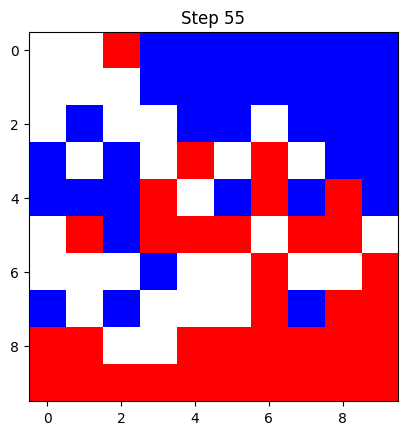

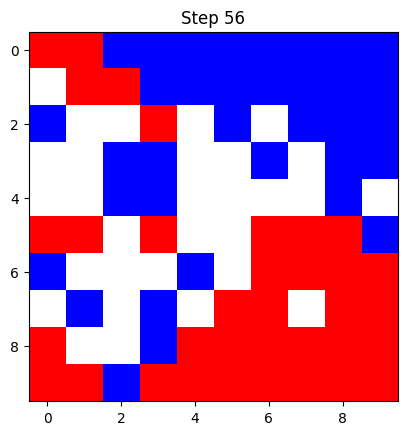

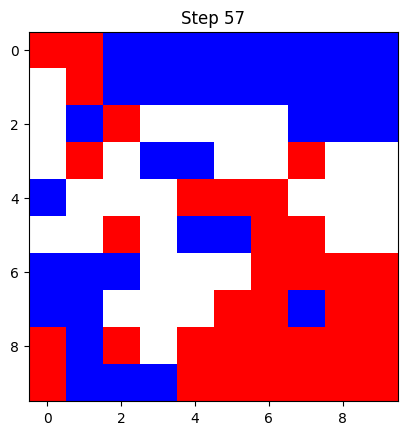

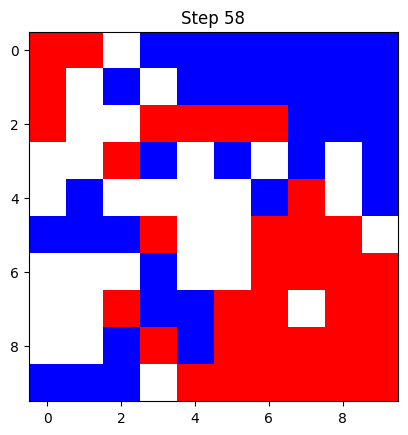

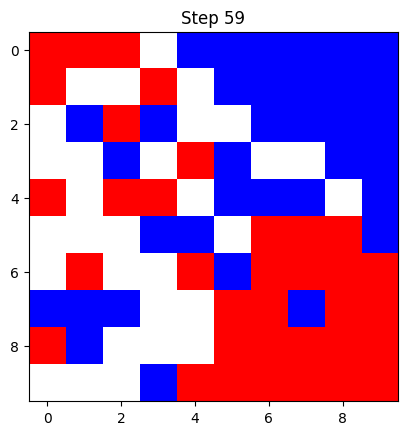

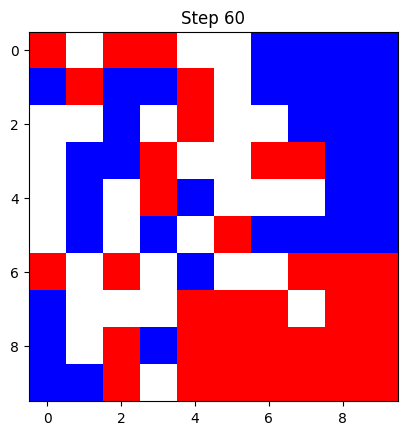

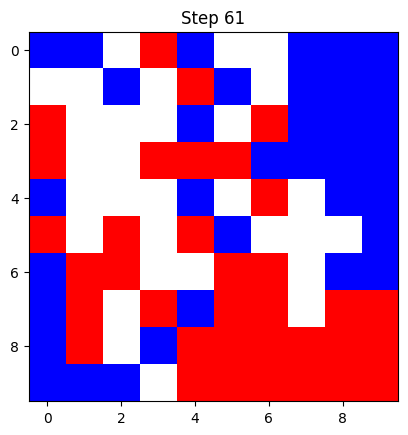

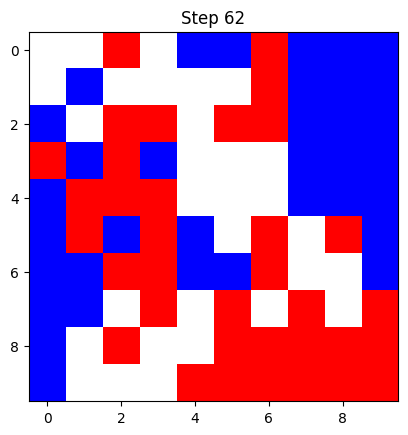

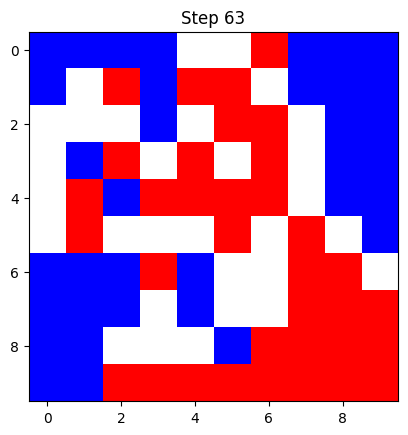

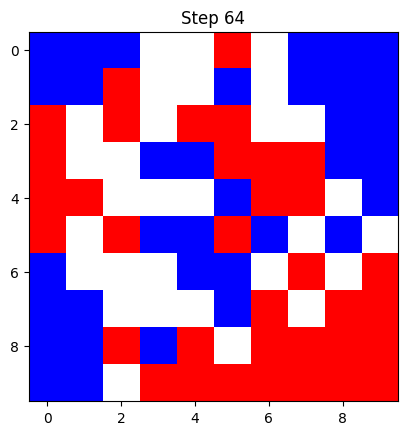

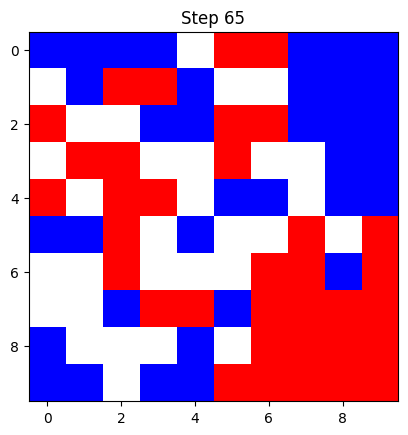

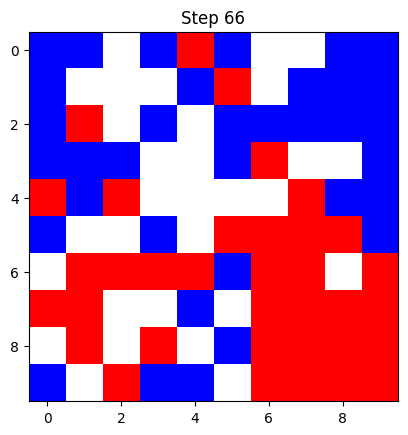

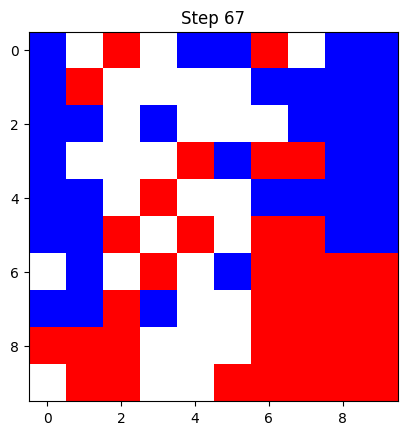

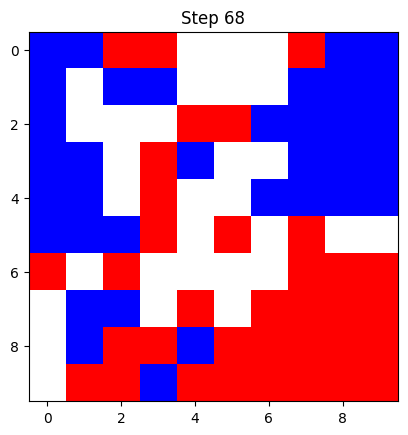

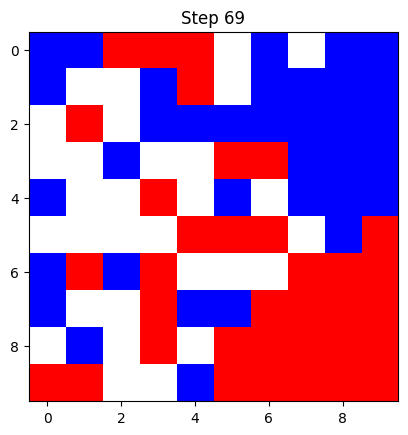

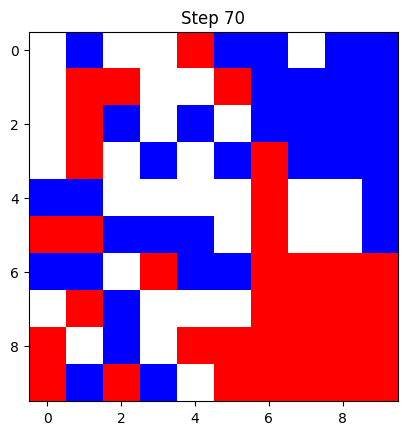

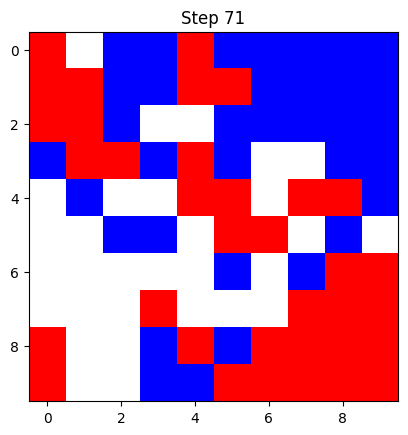

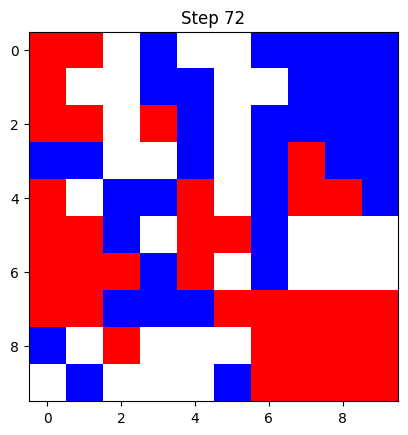

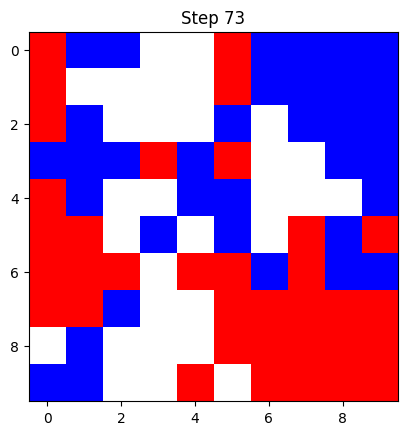

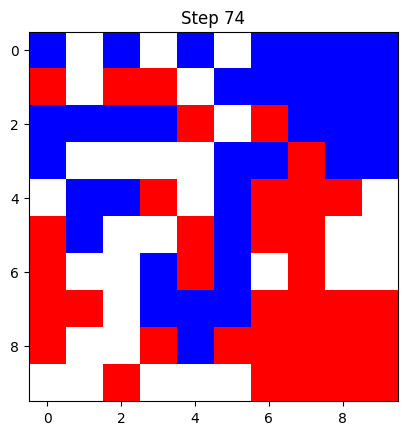

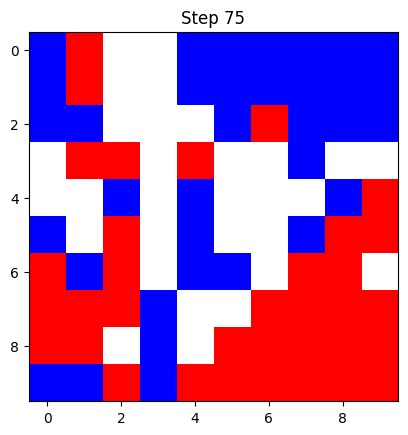

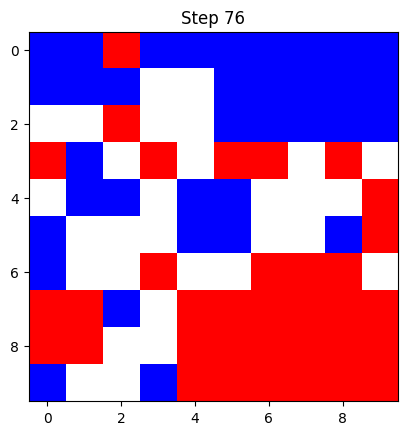

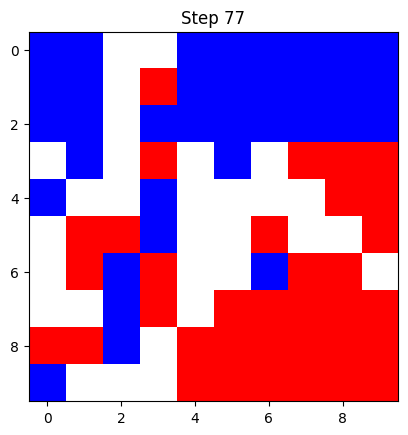

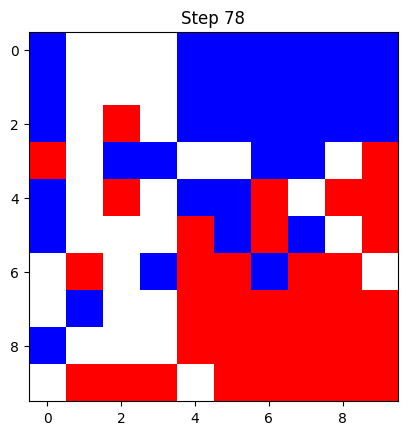

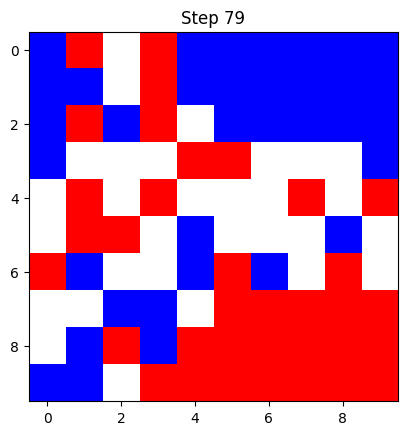

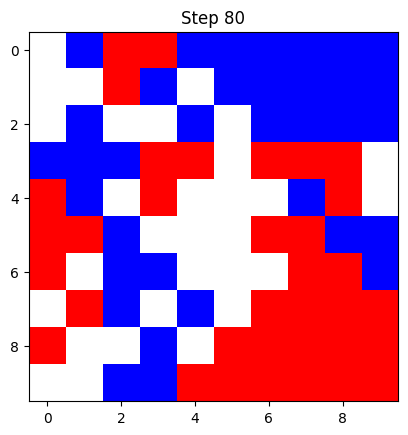

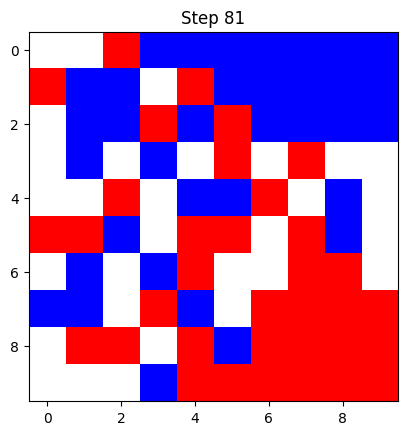

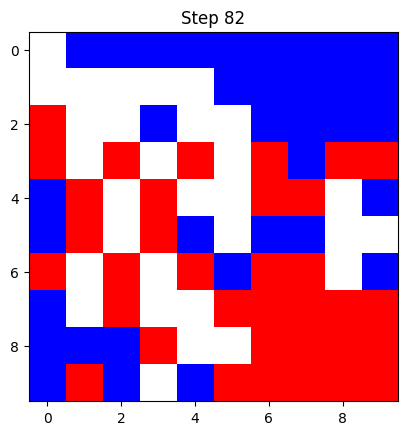

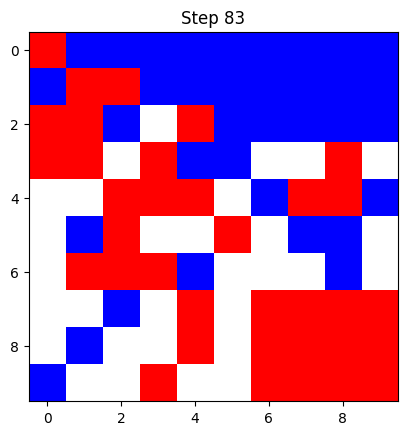

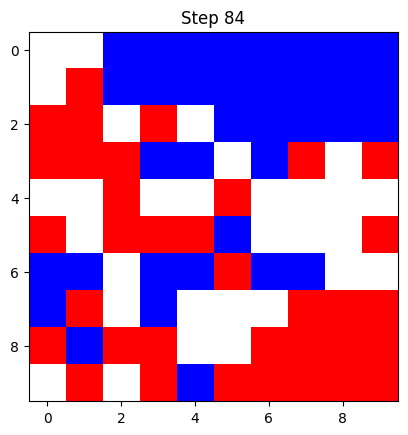

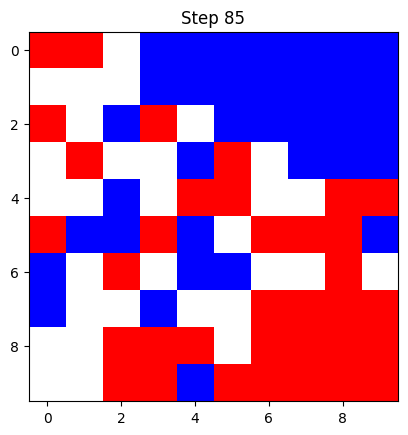

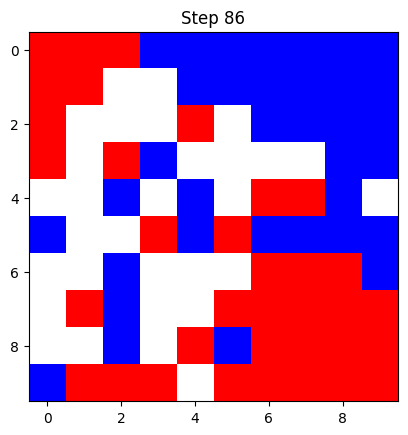

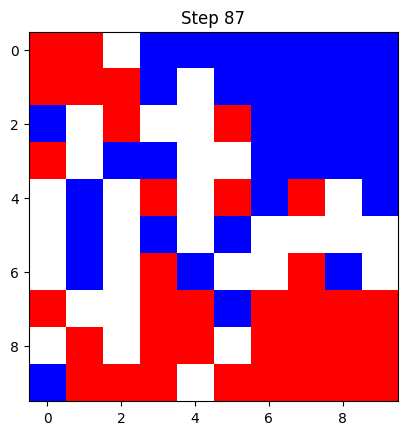

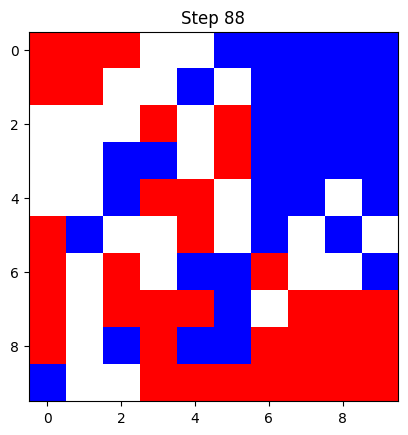

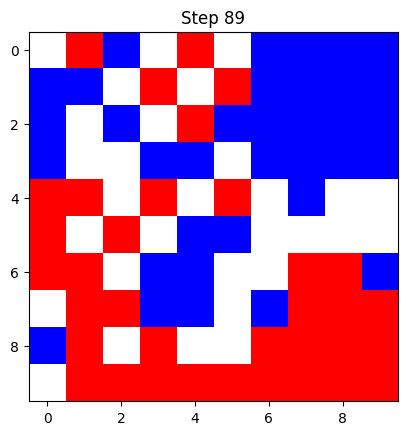

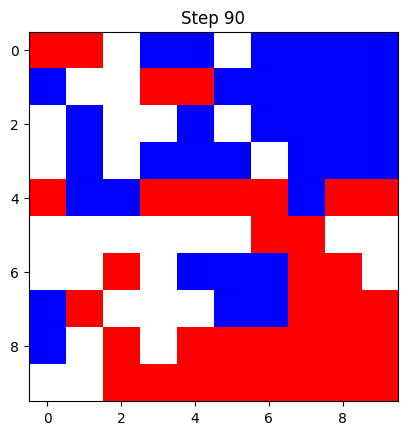

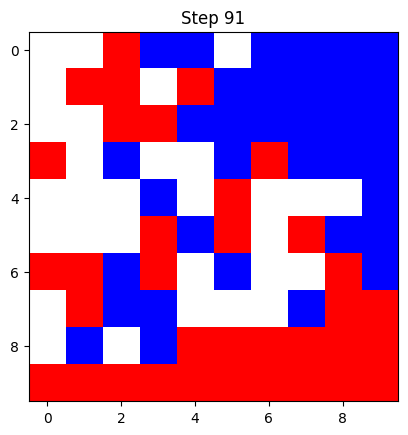

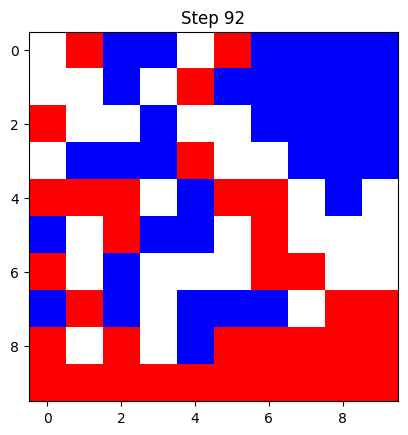

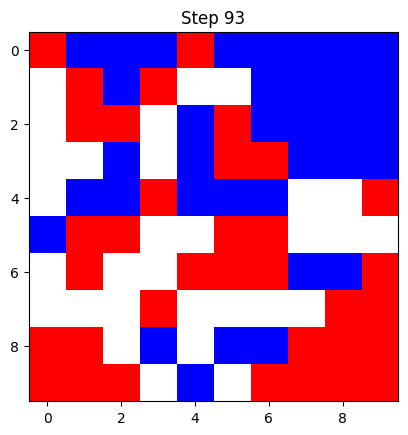

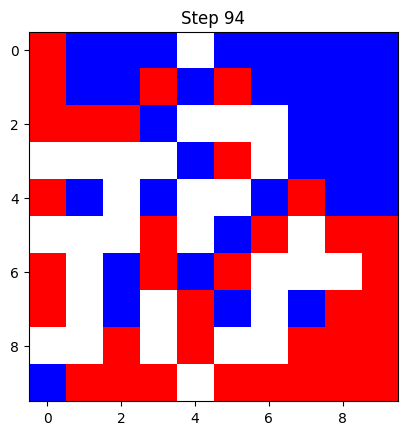

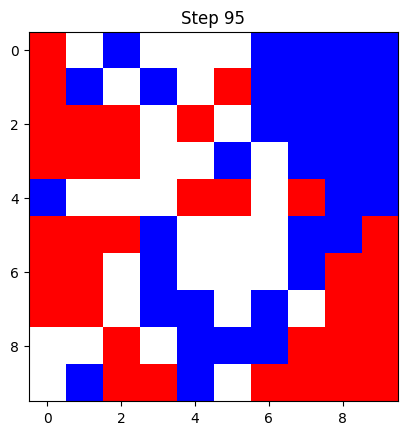

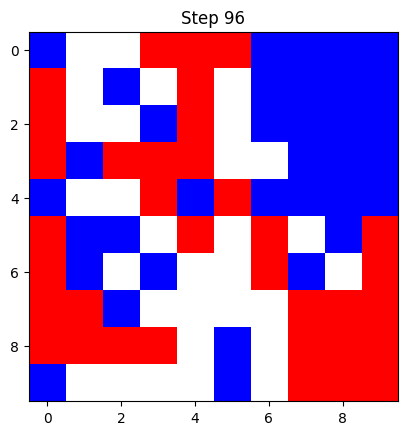

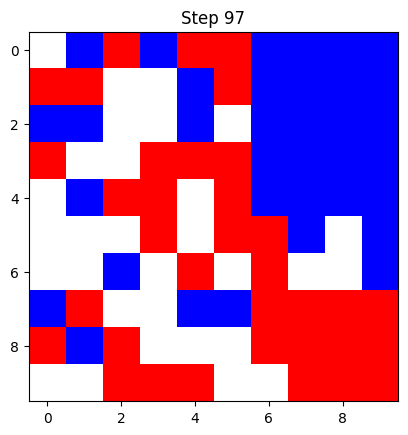

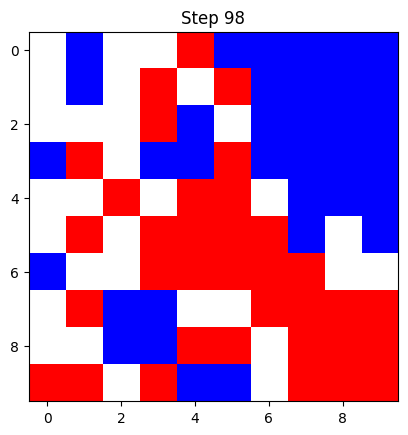

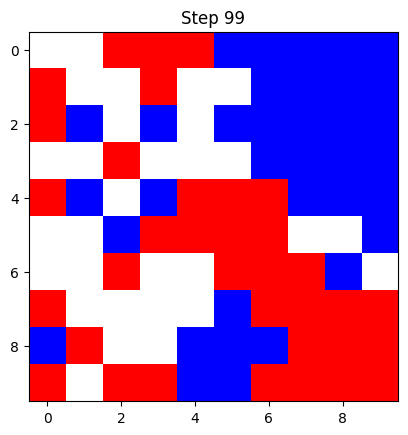

Final Grid:


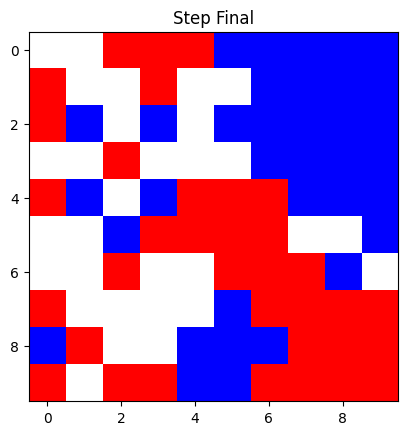

Simulation Results:
Initial Segregation: 0.34
Final Segregation: 0.58
Number of Agents Moved: 3647


<Figure size 640x480 with 0 Axes>

In [11]:
class Agent:
    """
    Represents an agent in the Schelling Model, characterized by its position and type.

    Attributes:
        x, y (int): The agent's coordinates on the grid.
        type (str): The agent's type, either 'red' or 'blue'.
    """

    def __init__(self, x, y, agent_type):
        self.x = x
        self.y = y
        self.type = agent_type

class City:
    """
    Simulates a city grid in the Schelling Model, where agents (red and blue) occupy a grid
    and move based on contentedness, determined by their neighbors.

    Attributes:
        width, height (int): Dimensions of the grid.
        vacancy_rate (float): Proportion of vacant cells.
        red_percentage (float): Percentage of red agents.
        contentedness (float): Threshold for agent satisfaction.
        grid (list[list]): 2D grid with agents or None.
        agents (list[Agent]): List of all agents.
        moved_count (int): Number of agent moves.
        initial_segregation, final_segregation (float): Segregation levels.

    Methods:
        initialize_city(): Sets up the grid with agents and vacant spots.
        get_neighbors(x, y): Finds neighbors of a cell.
        calculate_happiness(agent): Checks if an agent is content.
        calculate_segregation(): Computes segregation level.
        move_agent(agent): Moves an unhappy agent to a vacant spot.
        run_simulation(max_steps): Runs the model until equilibrium.
        display_grid(step): Visualizes the grid.
        print_results(): Outputs simulation results.
    """

    def __init__(self, width, height, vacancy_rate, red_percentage, contentedness):
        self.width = width
        self.height = height
        self.vacancy_rate = vacancy_rate
        self.red_percentage = red_percentage
        self.contentedness = contentedness
        self.grid = [[None for _ in range(self.width)] for _ in range(self.height)]
        self.agents = []
        self.moved_count = 0
        self.initial_segregation = 0
        self.final_segregation = 0
        self.initialize_city()

    def initialize_city(self):
        """
        Initializes the city grid with agents and vacant lots based on input parameters.
        """
        num_cells = self.width * self.height
        num_vacant = int(num_cells * self.vacancy_rate)
        num_agents = num_cells - num_vacant
        num_red = int(num_agents * self.red_percentage)
        num_blue = num_agents - num_red

        vacant_positions = random.sample(range(num_cells), num_vacant)
        for pos in vacant_positions:
            x, y = divmod(pos, self.width)
            self.grid[x][y] = None

        all_positions = set(range(num_cells))
        available_positions = list(all_positions - set(vacant_positions))
        agent_positions = random.sample(available_positions, num_agents)

        for i, pos in enumerate(agent_positions):
            x, y = divmod(pos, self.width)
            agent_type = 'red' if i < num_red else 'blue'
            agent = Agent(x, y, agent_type)
            self.grid[x][y] = agent
            self.agents.append(agent)

        self.initial_segregation = self.calculate_segregation()

    def get_neighbors(self, x, y):
        """
        Gets the neighbors of a specific cell in the grid.
        """
        neighbors = []
        for dx, dy in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.height and 0 <= ny < self.width:
                neighbors.append(self.grid[nx][ny])
        return neighbors

    def calculate_happiness(self, agent):
        """
        Determines if the agent is happy based on its neighbors.
        """
        neighbors = self.get_neighbors(agent.x, agent.y)
        similar_neighbors = sum(1 for neighbor in neighbors if neighbor and neighbor.type == agent.type)
        return similar_neighbors / len(neighbors) >= self.contentedness if neighbors else True

    def calculate_segregation(self):
        """
        Calculates the segregation level of the city.
        """
        total_agents = 0
        total_similar_neighbors = 0

        for agent in self.agents:
            neighbors = self.get_neighbors(agent.x, agent.y)
            similar_neighbors = sum(1 for neighbor in neighbors if neighbor and neighbor.type == agent.type)
            total_similar_neighbors += similar_neighbors
            total_agents += len(neighbors)

        return total_similar_neighbors / total_agents if total_agents > 0 else 0

    def move_agent(self, agent):
        """
        Moves an unhappy agent to a random vacant spot.
        """
        vacant_positions = [(x, y) for x in range(self.height) for y in range(self.width) if self.grid[x][y] is None]
        if vacant_positions:
            new_x, new_y = random.choice(vacant_positions)
            self.grid[agent.x][agent.y] = None
            agent.x, agent.y = new_x, new_y
            self.grid[new_x][new_y] = agent
            self.moved_count += 1

    def run_simulation(self, max_steps=100):
        """
        Runs the simulation until equilibrium or a maximum number of steps.
        """
        for step in range(max_steps):
            moved = 0
            for agent in self.agents:
                if not self.calculate_happiness(agent):
                    self.move_agent(agent)
                    moved += 1

            self.display_grid(step)

            if moved == 0:
                break

        self.final_segregation = self.calculate_segregation()

    def display_grid(self, step=None):
        """
        Visualizes the grid using Matplotlib.
        """
        grid_colors = np.zeros((self.height, self.width))
        for x in range(self.height):
            for y in range(self.width):
                if self.grid[x][y] is not None:
                    grid_colors[x][y] = 1 if self.grid[x][y].type == 'red' else 2

        cmap = ListedColormap(['white', 'red', 'blue'])
        plt.imshow(grid_colors, cmap=cmap, interpolation='nearest')
        if step is not None:
            plt.title(f"Step {step}")
        plt.pause(0.5)
        plt.clf()

    def print_results(self):
        """
        Prints the results after the simulation.
        """
        print("Simulation Results:")
        print(f"Initial Segregation: {self.initial_segregation:.2f}")
        print(f"Final Segregation: {self.final_segregation:.2f}")
        print(f"Number of Agents Moved: {self.moved_count}")


def main():
    """
    Main function to run the Schelling Model simulation.
    """
    width = int(input("Enter city width: "))
    height = int(input("Enter city height: "))
    vacancy_rate = float(input("Enter vacancy rate (0 to 1): "))
    red_percentage = float(input("Enter percentage of red agents (0 to 1): "))
    contentedness = float(input("Enter contentedness level (0 to 1): "))

    city = City(width, height, vacancy_rate, red_percentage, contentedness)
    print("Initial Grid:")
    city.display_grid(0)
    city.run_simulation()
    print("Final Grid:")
    city.display_grid("Final")
    city.print_results()


main()

In [12]:
#Unit test for City and Agent classes

def test_city_initialization():
    city = City(width=5, height=5, vacancy_rate=0.2, red_percentage=0.5, contentedness=0.5)
    num_cells = city.width * city.height
    num_vacant = int(num_cells * city.vacancy_rate)
    num_agents = num_cells - num_vacant

    # Check correct number of agents and vacant cells
    assert len(city.agents) == num_agents, "Incorrect number of agents"
    vacant_count = sum(1 for row in city.grid for cell in row if cell is None)
    assert vacant_count == num_vacant, "Incorrect number of vacant cells"

def test_get_neighbors():
    city = City(width=3, height=3, vacancy_rate=0.1, red_percentage=0.5, contentedness=0.5)
    neighbors = city.get_neighbors(1, 1)
    assert len(neighbors) == 8, "Neighbors count should be 8 for center cell"
    edge_neighbors = city.get_neighbors(0, 0)
    assert len(edge_neighbors) == 3, "Neighbors count should be 3 for corner cell"

def test_happiness():
    city = City(width=3, height=3, vacancy_rate=0.1, red_percentage=0.5, contentedness=0.5)
    agent = city.agents[0]
    happiness = city.calculate_happiness(agent)
    assert isinstance(happiness, bool), "Happiness should return a boolean"

def test_agent_movement():
    city = City(width=3, height=3, vacancy_rate=0.3, red_percentage=0.5, contentedness=0.5)
    agent = city.agents[0]
    initial_position = (agent.x, agent.y)

    city.move_agent(agent)
    new_position = (agent.x, agent.y)
    assert initial_position != new_position, "Agent should have moved"
    assert city.grid[initial_position[0]][initial_position[1]] is None, "Old position should be vacant"
    assert city.grid[new_position[0]][new_position[1]] == agent, "New position should be occupied by the agent"

def test_segregation_calculation():
    city = City(width=3, height=3, vacancy_rate=0.1, red_percentage=0.5, contentedness=0.5)
    segregation = city.calculate_segregation()
    assert 0 <= segregation <= 1, "Segregation should be between 0 and 1"

# Run the tests and print an output
test_city_initialization()
print("test_city_initialization passed.")

test_get_neighbors()
print("test_get_neighbors passed.")

test_happiness()
print("test_happiness passed.")

test_agent_movement()
print("test_agent_movement passed.")

test_segregation_calculation()
print("test_segregation_calculation passed.")

test_city_initialization passed.
test_get_neighbors passed.
test_happiness passed.
test_agent_movement passed.
test_segregation_calculation passed.


## Integrity statement

Please briefly describe all references you used, all help you received and all help you gave to others in completing this assignment. Be sure to say that you got no help if you got none.

FIXME